http://www.sidra.ibge.gov.br/bda/tabela/listabl.asp?z=t&o=22&i=P&c=3653

https://dadosdadosdados.wordpress.com/2015/09/25/trabalhando-com-series-temporais-no-r-parte-i-2/

In [563]:
%matplotlib inline
from unidecode import unidecode
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.regularizers import l2, activity_l2

from sklearn.metrics import r2_score

In [564]:
dataset = pd.read_csv('PIN.csv', sep=';', skiprows=3,header=1,skipfooter=1, engine='python', encoding='ISO-8859-1')
dataset.columns = [unidecode(x) for x in dataset.columns]

In [565]:
dataset.columns

Index([u'Unnamed: 0', u'Brasil', u'Amazonas', u'Para', u'Ceara', u'Pernambuco',
       u'Bahia', u'Minas Gerais', u'Espirito Santo', u'Rio de Janeiro',
       u'Sao Paulo', u'Parana', u'Santa Catarina', u'Rio Grande do Sul',
       u'Mato Grosso', u'Goias'],
      dtype='object')

In [566]:
for c in dataset.columns[1:]:
    dataset[c] = dataset[c].str.replace(',','.').replace('-',np.nan).astype(float)


In [567]:
dataset.head()

,Unnamed: 0,Brasil,Amazonas,Para,Ceara,Pernambuco,Bahia,Minas Gerais,Espirito Santo,Rio de Janeiro,Sao Paulo,Parana,Santa Catarina,Rio Grande do Sul,Mato Grosso,Goias
0,janeiro 2002,72.4,59.1,53.0,89.7,77.9,81.1,73.0,67.1,83.4,68.6,55.2,90.0,85.4,NaN,48.2
1,fevereiro 2002,69.7,57.9,55.1,80.2,66.3,72.4,66.8,61.5,77.3,68.0,56.2,89.4,84.3,NaN,55.8
2,março 2002,77.4,65.5,61.6,88.0,67.0,78.3,75.7,62.9,84.8,74.8,62.2,93.8,98.8,NaN,62.3
3,abril 2002,79.6,73.7,59.3,90.6,67.7,75.0,72.7,66.8,86.9,76.8,65.1,98.3,108.2,NaN,63.4
4,maio 2002,80.4,66.7,58.8,90.4,67.8,72.4,74.8,67.8,88.3,79.6,62.7,96.2,109.8,NaN,63.8


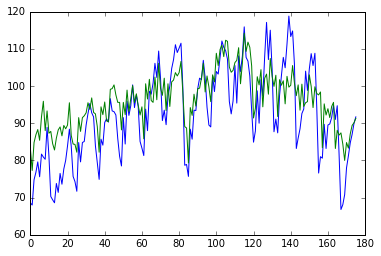

In [568]:
plt.plot(dataset['Sao Paulo'])
plt.plot(dataset['Rio de Janeiro'])
#plt.plot(dataset['Rio Grande do Sul'])

In [569]:
# fix random seed for reproducibility
numpy.random.seed(42)

In [570]:
# load the dataset
# remove columns
#del dataset['Unnamed: 0']
del dataset['Brasil']

### Add trend and seasonal factor

In [571]:
#seasonal = pd.get_dummies(dataframe['DATA'].apply(lambda x: int(str(x).split('.')[-1])))
#seasonal.columns = ['D'+str(x) for x in range(1,12)]

In [572]:
#data = pd.concat([dataframe, seasonal], axis=1)
#data['TREND'] = range(0, dataframe.shape[0])

In [573]:
#data['LAG_IBC_BR'] = data.groupby(['DATA'])['IBC_BR'].mean().shift(1).reset_index(drop=True)

In [574]:
#data = data.rename(columns={'IBC_BR':'TARGET'})

In [575]:
#data = data.fillna(0)

In [576]:
#del data['DATA']

In [577]:
def date_convertator(series):
    months = {'janeiro':'01',
              'fevereiro':'02',
              'marco':'03',
              'abril':'04',
              'maio':'05',
              'junho':'06',
              'julho':'07',
              'agosto':'08',
              'setembro':'09',
              'outubro':'10',
              'novembro':'11',
              'dezembro':'12'}

    dates = series.str.split(' ', expand=True)
    dates[0] = dates[0].apply(lambda x: unidecode(x))
    for key, value in months.iteritems():

        dates[0] = dates[0].str.replace(key, value)

    date_vec = pd.to_datetime(dates[1]+ '-' + dates[0])
    return date_vec

In [578]:
dataset['Date'] = date_convertator(dataset['Unnamed: 0'])
del dataset['Unnamed: 0']

In [579]:
dataset.head()

,Amazonas,Para,Ceara,Pernambuco,Bahia,Minas Gerais,Espirito Santo,Rio de Janeiro,Sao Paulo,Parana,Santa Catarina,Rio Grande do Sul,Mato Grosso,Goias,Date
0,59.1,53.0,89.7,77.9,81.1,73.0,67.1,83.4,68.6,55.2,90.0,85.4,NaN,48.2,2002-01-01
1,57.9,55.1,80.2,66.3,72.4,66.8,61.5,77.3,68.0,56.2,89.4,84.3,NaN,55.8,2002-02-01
2,65.5,61.6,88.0,67.0,78.3,75.7,62.9,84.8,74.8,62.2,93.8,98.8,NaN,62.3,2002-03-01
3,73.7,59.3,90.6,67.7,75.0,72.7,66.8,86.9,76.8,65.1,98.3,108.2,NaN,63.4,2002-04-01
4,66.7,58.8,90.4,67.8,72.4,74.8,67.8,88.3,79.6,62.7,96.2,109.8,NaN,63.8,2002-05-01


In [580]:
def laggator(df, lags=12):
    data = pd.melt(df.groupby('Date').sum().reset_index(),id_vars='Date')
    
    for l in range(1,lags+1):
        zero = pd.melt(df.groupby('Date').sum().shift(l-1).reset_index(),id_vars='Date')['value']  
        data['L' + str(l-1)] = zero / pd.melt(df.groupby('Date').sum().shift(l).reset_index(),id_vars='Date')['value']-1
    
    return data

In [581]:
LAGS = 13
data = laggator(dataset, LAGS)
data = data.fillna(0)
true_val = data['value']
del data['value']

In [582]:
data.ix[data.variable=='Sao Paulo',:].head()

,Date,variable,L0,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12
1408,2002-01-01,Sao Paulo,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1409,2002-02-01,Sao Paulo,-0.008746,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1410,2002-03-01,Sao Paulo,0.100000,-0.008746,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1411,2002-04-01,Sao Paulo,0.026738,0.100000,-0.008746,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1412,2002-05-01,Sao Paulo,0.036458,0.026738,0.100000,-0.008746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [583]:
CUTOFF = '2015-01-01'

In [584]:
train = data.ix[data['Date']<CUTOFF,:]
test = data.ix[data['Date']>=CUTOFF,:]

In [585]:
train.head()

,Date,variable,L0,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12
0,2002-01-01,Amazonas,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2002-02-01,Amazonas,-0.020305,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2002-03-01,Amazonas,0.131261,-0.020305,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2002-04-01,Amazonas,0.125191,0.131261,-0.020305,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2002-05-01,Amazonas,-0.094980,0.125191,0.131261,-0.020305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# check this

http://stackoverflow.com/questions/36992855/keras-how-should-i-prepare-input-data-for-rnn

In [586]:
FEAT = 1
LAGS = 12
traX = np.zeros((train.shape[0], LAGS, features))
tesX = np.zeros((test.shape[0], LAGS, features))
traY = np.zeros((train.shape[0]))
tesY = np.zeros((test.shape[0]))

for f in range(features):
    traX[:,:,f] = train.ix[:, 3:]
    tesX[:,:,f] = test.ix[:, 3:]

traY = train['L0']
tesY = test['L0']

In [587]:
traX.shape, traY.shape

((2184, 12, 1), (2184,))

In [588]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(128, input_dim=traX.shape[2], return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
#model.add(Dropout(0.2))
#model.add(LSTM(128,return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(12))
#model.add(Flatten())
model.add(Dense(1, W_regularizer=l2(1e-6), activity_regularizer=activity_l2(1e-6)))
model.compile(loss='mean_squared_error', optimizer='rmsprop')

hist = model.fit(traX, traY, nb_epoch=60, batch_size=1, verbose=2, validation_split=0.3)

Train on 1528 samples, validate on 656 samples
Epoch 1/60
10s - loss: 0.0053 - val_loss: 0.0041
Epoch 2/60
9s - loss: 0.0041 - val_loss: 0.0041
Epoch 3/60
10s - loss: 0.0041 - val_loss: 0.0050
Epoch 4/60
9s - loss: 0.0041 - val_loss: 0.0035
Epoch 5/60
11s - loss: 0.0040 - val_loss: 0.0037
Epoch 6/60
13s - loss: 0.0040 - val_loss: 0.0036
Epoch 7/60
10s - loss: 0.0039 - val_loss: 0.0037
Epoch 8/60
11s - loss: 0.0039 - val_loss: 0.0034
Epoch 9/60
10s - loss: 0.0039 - val_loss: 0.0034
Epoch 10/60
10s - loss: 0.0038 - val_loss: 0.0040
Epoch 11/60
9s - loss: 0.0038 - val_loss: 0.0037
Epoch 12/60
15s - loss: 0.0037 - val_loss: 0.0035
Epoch 13/60
10s - loss: 0.0037 - val_loss: 0.0039
Epoch 14/60
10s - loss: 0.0037 - val_loss: 0.0034
Epoch 15/60
10s - loss: 0.0037 - val_loss: 0.0033
Epoch 16/60
10s - loss: 0.0036 - val_loss: 0.0034
Epoch 17/60
11s - loss: 0.0036 - val_loss: 0.0035
Epoch 18/60
10s - loss: 0.0035 - val_loss: 0.0033
Epoch 19/60
11s - loss: 0.0035 - val_loss: 0.0040
Epoch 20/60
12s

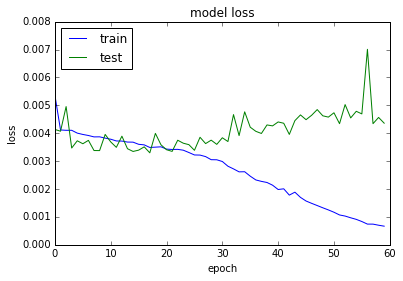

In [589]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [590]:
# generate predictions for training
trainPredict = model.predict(traX)
testPredict = model.predict(tesX)

In [591]:
trainPredict.shape

(2184, 1)

In [592]:
final = data[['Date', 'variable']]
final.ix[:, 'true_val'] = true_val
final.ix[final['Date']<CUTOFF, 'train_pred'] = trainPredict
final.ix[final['Date']>=CUTOFF, 'test_pred'] = testPredict
final['train'] = final['true_val'] * (1+final['train_pred'])
final['test'] = final['true_val'] * (1+final['test_pred'])

/home/sandor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sandor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [593]:
final[final['variable']=='Sao Paulo'].head()

,Date,variable,true_val,train_pred,test_pred,train,test
1408,2002-01-01,Sao Paulo,68.6,-0.011952,NaN,67.780086,NaN
1409,2002-02-01,Sao Paulo,68.0,-0.011952,NaN,67.187257,NaN
1410,2002-03-01,Sao Paulo,74.8,0.014879,NaN,75.912959,NaN
1411,2002-04-01,Sao Paulo,76.8,0.003538,NaN,77.071706,NaN
1412,2002-05-01,Sao Paulo,79.6,0.009360,NaN,80.345086,NaN


In [594]:
data.variable.unique()

array(['Amazonas', 'Para', 'Ceara', 'Pernambuco', 'Bahia', 'Minas Gerais',
       'Espirito Santo', 'Rio de Janeiro', 'Sao Paulo', 'Parana',
       'Santa Catarina', 'Rio Grande do Sul', 'Mato Grosso', 'Goias'], dtype=object)

In [621]:
est = []
tr = []
te = []
for e in final['variable'].unique():
    f1 = (final['variable']==e) & (final['Date']<CUTOFF)
    f2 = (final['variable']==e) & (final['Date']>=CUTOFF)
    
    est.append(e)
    tr.append(r2_score(final.ix[f1,'true_val'],final.ix[f1,'train']))
    te.append(r2_score(final.ix[f2,'true_val'],final.ix[f2,'test']))
    
pd.DataFrame({'estado':est, 'train':tr, 'test':te})[['estado', 'train', 'test']]
    

,estado,train,test
0,Amazonas,0.489520,0.263826
1,Para,0.805150,0.202032
2,Ceara,0.525175,0.280528
3,Pernambuco,0.706263,0.726762
4,Bahia,0.568817,0.068741
5,Minas Gerais,0.780038,0.563051
6,Espirito Santo,0.814110,0.738749
7,Rio de Janeiro,0.526824,-0.674779
8,Sao Paulo,0.704020,0.555043
9,Parana,0.772015,0.402793


0.704019538022 0.555043312468


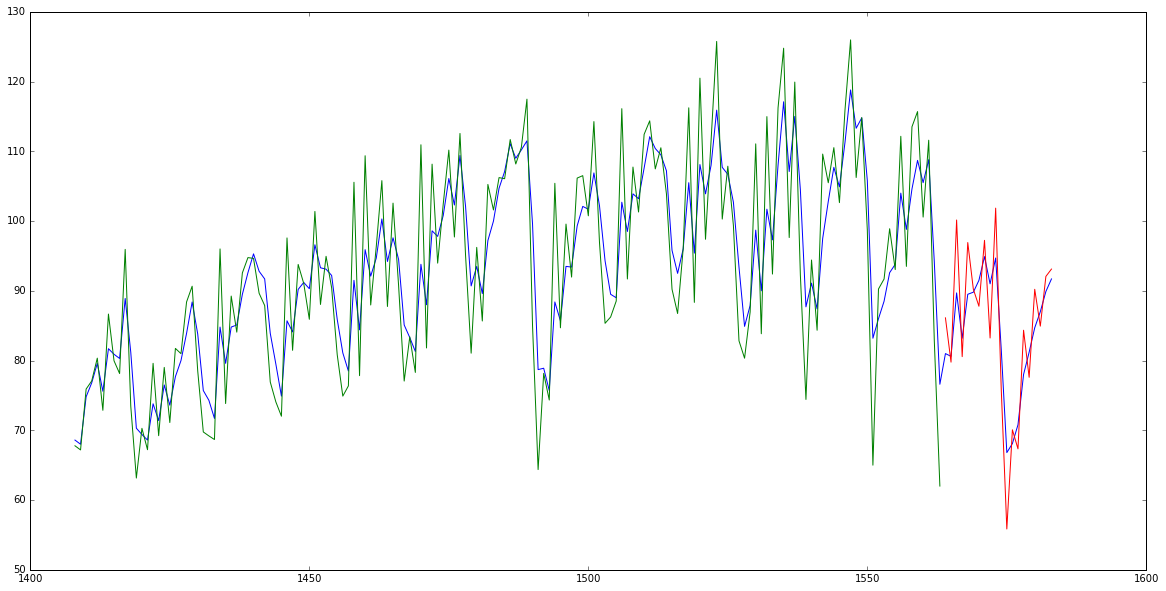

In [609]:
# plot baseline and predictions
estado = 'Sao Paulo'
f1 = (final['variable']==estado) & (final['Date']<CUTOFF)
f2 = (final['variable']==estado) & (final['Date']>=CUTOFF)

print r2_score(final.ix[f1,'true_val'],final.ix[f1,'train']), r2_score(final.ix[f2,'true_val'],final.ix[f2,'test'])

plt.figure(figsize=(20,10))
plt.plot(final.ix[final['variable']==estado, 'true_val'])
plt.plot(final.ix[final['variable']==estado, 'train'])
plt.plot(final.ix[final['variable']==estado, 'test'])
